# Are Amazon product reviews generally more positive/negative for certain categories compared to others?
A reliable indication of whether a customer appreciates a particular product is evident in their positive review, while dissatisfaction is often reflected in negative feedback. However, discerning what defines a good review versus a bad one poses a challenge. Can the star rating alone serve as a definitive indicator of a customer's satisfaction with a product? In this section of the notebook, our focus is on comparing the star ratings and sentiment values across various product categories, aiming to shed light on the relationship between these two evaluative metrics.

Moreover, the comparison between different categories enables the identification of products that resonate more with the general customer base. It also provides insights into the reviewing behavior of customers across diverse product categories. For instance, are customers in the tech sector, who purchase electronics and software, more inclined to leave negative reviews? Maybe, due to the products being prone to errors compared to, for example, customers who buy eBooks and Gift Cards?

By exploring these aspects, we aim to gain a nuanced understanding of how customers perceive and review products across different categories, thereby contributing to a more comprehensive analysis of the dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, count, col, coalesce, lit, avg, concat_ws, mean, stddev, var_samp, expr
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql import SparkSession
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Not in Requirements, poetry add vaderSentiment
from textblob import TextBlob

##
## Set this flag to True, if you want to generate all the .parquets used in this part of the notebook
## If set to False, the notebook tries to just read them in from the /data folder
##
generate = False
print('This run will generate all the .parquet files!') if generate else print('This run will read the .parquet files from /data!')


spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "6g").config("spark.executor.memory", "6g").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","12g").getOrCreate()

data = spark.read.parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
print(f"Shape of the DataFrame: ({data.count()}, {len(data.columns)})")

This run will read the .parquet files from /data!


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/22 19:10:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Shape of the DataFrame: (230139802, 27)


## Outlier Detection and Handling
Interestingly, the dataset contains 9 rows, all having an overall star rating of 0 stars. However, when considering the vast size of the entire dataset, which consists of 230,139,802 rows, these 9 entries are realistically insignificant. As a result, we have excluded them from our analysis. Including them would only serve to complicate the plots and data without providing any meaningful additional information gain. Additionally, looking at the review summary of those rows, classifies them even more as outliers, because the text 'Goog Read' would typically not result in a rating of 0 stars.

In [2]:
data[data['overall'] == 0.0][['overall', 'summary', 'reviewText']].show()
data = data.filter(data['overall'] != 0.0)

+-------+--------------------+--------------------+
|overall|             summary|          reviewText|
+-------+--------------------+--------------------+
|    0.0|Blurb from inside...|The fundamental s...|
|    0.0|Old world knowled...|From the back cov...|
|    0.0|              Rating|The story was goo...|
|    0.0|A pretty little book|A pretty little b...|
|    0.0|Vividly colored r...|This is the artis...|
|    0.0|           Good Read|Beneath a Scarlet...|
|    0.0|           Good Read|Beneath a Scarlet...|
|    0.0|                Wow!|I cried throughou...|
|    0.0|            Readable|A lot of mistakes...|
+-------+--------------------+--------------------+



## Star Ratings Analysis
To address the question of whether Amazon reviews exhibit a tendency to be more positive or negative across different categories, we chose to compare them using two metrics. The first metric examines the overall star rating of the reviews, investigating for example whether certain categories receive more 5-star reviews than others and examining the general distribution of star ratings.

### Data Preparation
After handling outliers, a star rating can now range from 1 star to 5 stars, with 5 stars representing the highest rating. To facilitate meaningful comparisons across different categories, we computed the total number of reviews for each possible star rating and the average rating for each category.

In [3]:
##
## Groups by Category and counts the number of ratings per Star Rating
## Returned Columns: 'category', 'stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5', 'number_of_reviews', 'average_rating'
## Returned Dataframe is a Pandas Dataframe
##
def reduce_to_cat_stars(data):
    long_df = data.groupBy('category', 'overall').count()
    df = long_df.groupBy('category').pivot('overall').sum("count")

    for i in range(1, 6):
        df = df.withColumnRenamed(f"{i}.0", f"stars_{i}")

    df = df.withColumn('number_of_reviews', col('stars_1') + col('stars_2') + col('stars_3') + col('stars_4') + col('stars_5'))
    df = df.withColumn('average_rating', (col('stars_1') + col('stars_2') * 2 + col('stars_3') * 3 + col('stars_4') * 4 + col('stars_5') * 5) / col('number_of_reviews'))

    df = df.orderBy('category')
    return df.toPandas()


data_cat_stars = reduce_to_cat_stars(data)
data_cat_stars

24/01/22 19:10:25 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,category,stars_1,stars_2,stars_3,stars_4,stars_5,number_of_reviews,average_rating
0,AMAZON_FASHION,107080,64718,97031,149331,465476,883636,3.906940
1,All_Beauty,39261,20293,29555,52687,229549,371345,4.112093
2,Appliances,59627,20734,30652,75476,416288,602777,4.274209
3,Arts_Crafts_and_Sewing,210232,120994,198200,361840,1984651,2875917,4.317731
4,Automotive,734047,329578,503860,1065868,5356813,7990166,4.249263
5,Books,2088314,1850688,3835225,9557650,33979736,51311613,4.393248
6,CDs_and_Vinyl,165396,133374,277854,700943,3265802,4543369,4.489727
7,Cell_Phones_and_Accessories,1382543,654327,860610,1517552,5648223,10063255,3.933553
8,Clothing_Shoes_and_Jewelry,2271737,1804553,2982765,5707951,19525093,32292099,4.189458
9,Digital_Music,43108,23551,57347,179929,1280147,1584082,4.660555


### Plot and Review the Results
The following plot illustrates the percentage of reviews for each category corresponding to a specific star rating. Additionally, the categories are arranged in order of their average star rating, facilitating the identification of significant differences in star rating distribution. For instance, Gift Cards, Digital Music, and CDs and Vinyl exhibit relatively high average star ratings with a substantial number of 5-star reviews, in contrast to categories like Software products.

This disparity may arise from the nature of products such as Gift Cards and Digital Music, where issues are less likely to occur. Gift cards usually function seamlessly upon purchase, minimizing the likelihood of dissatisfaction leading to negative reviews. Similarly, with Digital Music and CDs and Vinyl, the ease of access to online music and the likelihood that purchasers genuinely enjoy the songs they buy contribute to higher satisfaction levels.

On the other hand, Software faces challenges like a high error rate, installation difficulties, and configuration complexities, which may result in a less favorable experience for users.

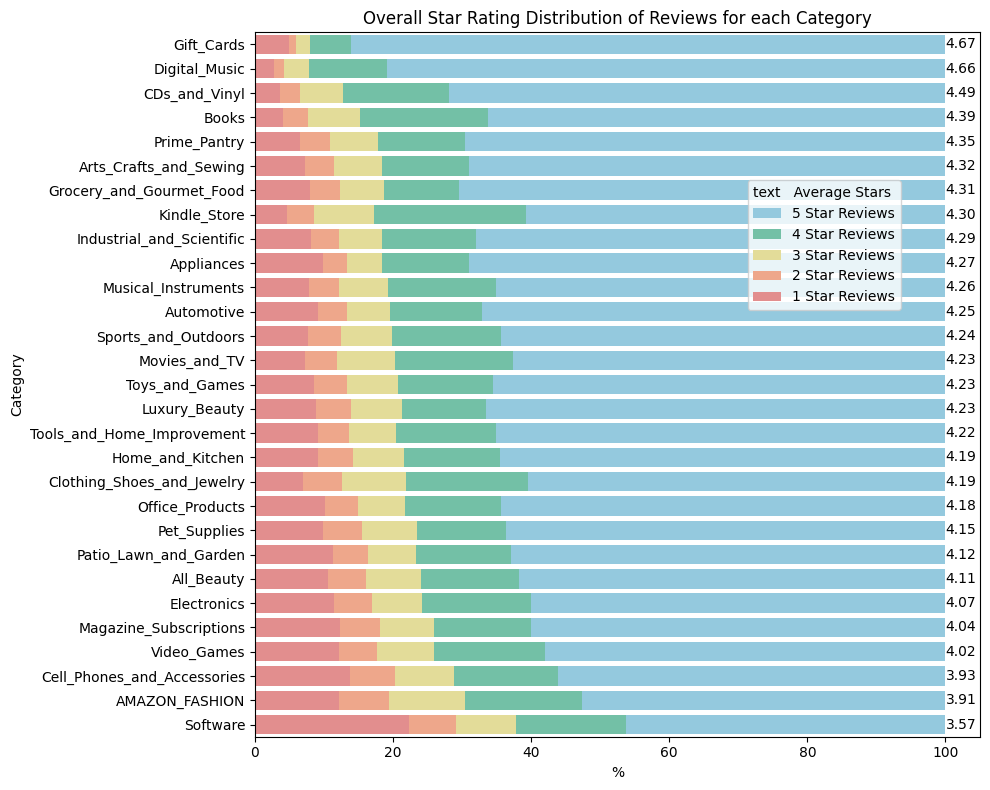

In [4]:
def plot_cat_stars(df_cat_stars):
    # Calculate comulative values
    com_df_cat_stars = df_cat_stars.copy()
    for i in range(1, 5):
        com_df_cat_stars[f'stars_{i+1}'] += com_df_cat_stars[f'stars_{i}']
    # Normalize and convert to Percent
    for i in range(1, 6):
        com_df_cat_stars[f'stars_{i}'] *= 100 / com_df_cat_stars[f'stars_5']

    com_df_cat_stars = com_df_cat_stars.sort_values(by=['average_rating'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='stars_5', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[0], label='5 Star Reviews')
    sns.barplot(x='stars_4', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[1], label='4 Star Reviews')
    sns.barplot(x='stars_3', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[2], label='3 Star Reviews')
    sns.barplot(x='stars_2', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[3], label='2 Star Reviews')
    sns.barplot(x='stars_1', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[4], label='1 Star Reviews')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_stars.iterrows():
        ax1.text(row['stars_5'], i, f'{row["average_rating"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Overall Star Rating Distribution of Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text   Average Stars', alignment='left')

    # Show the plot
    plt.show()

plot_cat_stars(data_cat_stars)

In [23]:
def outlier_detection(title, df, col_name):
    print(title)
    # print(df[col_name].describe())

    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1

    # Outliers
    print(df[(df[col_name] < Q1 - 1.5 * IQR) | (Q3 + 1.5 * IQR < df[col_name])][['category', col_name]])

outlier_detection('Average Star Rating Outliers', data_cat_stars, 'average_rating')

Average Star Rating Outliers
         category  average_rating
9   Digital_Music        4.660555
11     Gift_Cards        4.671970
24       Software        3.570175


## Sentiment Analysis
As a second metric, we opted to examine the distribution of sentiment values within both the summary and review text of the reviews. Our goal was to compare two distinct approaches: one utilizing the polarity compound score from the [Vader Sentiment Analysis tool](https://vadersentiment.readthedocs.io/en/latest/) and the polarity score from the [TextBlob Text Processing tool](https://textblob.readthedocs.io/en/dev/). As described in the article [Sentiment Analysis with TextBlob and Vader](https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/), TextBlob struggles a bit with negative sentences, especially with negations, which needs to be taken into account for the further analysis.

Regrettably, the Vader Sentiment Analyzer is computationally intensive, leading us to perform the analysis on a sample of the data. Conversely, TextBlob is more efficient in terms of computation, allowing us to calculate sentiment scores for the entire dataset. A comparative analysis was conducted between the two tools to better assess the overall data situation.

### Sampling the Dataset

The resulting sample contains either a fixed fraction or a minimum number of rows for each category. Given the considerable variation in sizes among different categories—such as 51 million reviews for Books and approximately 150,000 for Gift Cards in the dataset—using a fixed fraction for sampling presents challenges. Opting for a fixed fraction might underrepresent certain categories, making analysis challenging as the fraction for a category may consist of very few rows. Conversely, selecting too large a fraction renders the sample unwieldy and impractical for conducting Vader Analysis.

Choosing a fixed number of samples per category is also not advisable, as it would result in an extremely low fraction for larger categories, underrepresenting them and making predictions untrustworthy. To maintain comparability with the sentiment analysis and star ratings, we aimed to closely replicate the star rating distribution of the original dataset. This involved selecting a fraction for each star rating based on the number of rows within that rating. The slight deviations in averages and variances of the sample from the original data result from the way pySpark handles sampling, providing a sample that is close but not exactly the specified fraction. 

A comparison between the sample and the original dataset is done later in this section.

In [6]:
categories = sorted([row['category'] for row in data.select('category').distinct().collect()])

DISCLAIMER: Do not forget to set the 'generate'-flag in the top cell of this section, if you wish to generate all .parquets from scratch.

In [7]:
##
## Creates a sample of each category based on the star ratings, it therefore tries to follow the distribution of the star ratings in the original dataset as closely as possible
##
def sample_for_sentiment(filename, spark_session, frac = 0.00001, min_per_cat = 1000, verbose = False):
    mode = 'overwrite'
    for category in categories:
        if verbose:
            print(f"Currently subsampling category {category} ...")
        rows_of_category = spark_session.read.parquet(f'/data/{category}.parquet')
        rows_of_category = rows_of_category[['category', 'overall', 'verified', 'summary', 'reviewText']].dropna()

        frac = max(frac, min_per_cat / rows_of_category.count())
        fractions = {stars: frac for stars in range(1, 6)}
        sampled_rows = rows_of_category.sampleBy('overall', fractions, seed=42)

        sampled_rows.write.parquet(filename, mode=mode)
        mode = 'append'

filename = '/data/question1_data_sample.parquet'
sample_for_sentiment(filename, spark) if generate else None
data_sample = spark.read.parquet(filename)

To enhance the comparison between star ratings and sentiment values, we chose to categorize them into five groups, mirroring the five different star ratings. According to the Vader Sentiment Analyzer page, a compound score greater than 0.5 is generally considered positive, while a score lower than -0.5 is generally deemed negative. As for the TextBlob tool, no such predefined categorization was provided, so we applied the same criteria for both tools. Furthermore, we evenly distributed the intervals across the range of [-1, 1] to facilitate a clearer visualization of the data. It's important to note that in this analysis, a positive classification corresponds more to a positive tendency, and is not directly comparable to a positive classification of a three state model mentioned on the Vader webpage. 

In [8]:
##
## Removes unnecaccary columns and adds column for the sentiment analysis
##
def reduce_to_sentiment(df, calculate_score, score_col):
    df = df.withColumn('text', concat_ws(' - ', col('summary'), col('reviewText')))
    df = df.withColumn(score_col, calculate_score(df['text']))

    df = df[['category', 'overall', 'verified', score_col]]
    calculate_sentiment = udf(lambda compound: 'very_positive' if compound >= 0.6 
                                else ('positive' if compound >= 0.2
                                else ('very_negative' if compound <= -0.6 
                                else ('negative' if compound <= -0.2
                                else 'neutral'))), StringType())
    df = df.withColumn("sentiment", calculate_sentiment(df[score_col]))
    return df

def write_sentiment_parque(filename, spark_session, calculate_score, score_col):
    mode = 'overwrite'
    for category in categories:
        if verbose:
            print(f"Currently subsampling category {category} ...")
        rows_of_category = spark_session.read.parquet(f'/data/{category}.parquet')
        rows_of_category = rows_of_category[['category', 'overall', 'verified', 'summary', 'reviewText']].dropna()

        sentiment_rows = reduce_to_sentiment(rows_of_category, calculate_score, score_col)

        sentiment_rows.write.parquet(filename, mode=mode)
        mode = 'append'

### Data Preparation Vader Sentiment

In [9]:
## New Columns: 'vader_compound', 'sentiment'
def reduce_to_vader_sentiment(df):
    calculate_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'] if x else 0, DoubleType())
    col_name = 'vader_compound'
    return reduce_to_sentiment(df, calculate_score, col_name)

def write_vader_sentiment(filename, spark_session):
    calculate_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'] if x else 0, DoubleType())
    col_name = 'vader_compound'
    return write_sentiment_parque(filename, spark_session, calculate_score, col_name)

filename = '/data/question1_data_sample_vader_sentiment.parquet'

data_sample_vader_sentiment = reduce_to_vader_sentiment(data_sample) if generate else None
data_sample_vader_sentiment.write.parquet(filename, mode = 'overwrite') if generate else None

data_sample_vader_sentiment = spark.read.parquet(filename)

### Data Preparation TextBlob

In [10]:
## New Columns: 'textblob_polarity', 'sentiment'
def reduce_to_textblob_sentiment(df):
    calculate_score = udf(lambda x: TextBlob(x).polarity if x else 0, DoubleType())
    col_name = 'textblob_polarity'
    return reduce_to_sentiment(df, calculate_score, col_name)

def write_textblob_sentiment(filename, spark_session):
    calculate_score = udf(lambda x: TextBlob(x).polarity if x else 0, DoubleType())
    col_name = 'textblob_polarity'
    return write_sentiment_parque(filename, spark_session, calculate_score, col_name)

filename = '/data/question1_data_sample_textblob_sentiment.parquet'

data_sample_textblob_sentiment = reduce_to_textblob_sentiment(data_sample) if generate else None
data_sample_textblob_sentiment.write.parquet(filename, mode = 'overwrite') if generate else None

data_sample_textblob_sentiment = spark.read.parquet(filename)

Because TextBlob Polarity Analysis is significantly faster than Vader Sentiment, we were able to conduct the analysis on the entire dataset.

In [11]:
filename = '/data/question1_data_complete_textblob_sentiment.parquet'
write_textblob_sentiment(filename, spark) if generate else None
data_textblob_sentiment = spark.read.parquet(filename)

In [12]:
##
## Groups by Category and counts the number of ratings per sentiment class
## Resulting Columns: 'category', 'very_negative', 'negative', 'neutral', 'positive', 'very_positive', 'number_of_reviews', 'average_sentiment'
##
def reduce_to_cat_sentiment(data, score_col):
    long_df = data.groupBy('category', 'sentiment').count()
    df = long_df.groupBy('category').pivot('sentiment').sum("count")
    df = df.withColumn('number_of_reviews', col('very_negative') + col('negative') + col('neutral') + col('positive') + col('very_positive'))

    df = df.orderBy('category').toPandas()
    average_sentiment = data.groupBy("category").agg(avg(score_col).alias('average_sentiment')).toPandas().reset_index(drop=True)
    df = df.merge(average_sentiment, on='category', how='left')

    return df

data_sample_vader_cat_sentiment = reduce_to_cat_sentiment(data_sample_vader_sentiment, 'vader_compound')
data_sample_textblob_cat_sentiment = reduce_to_cat_sentiment(data_sample_textblob_sentiment, 'textblob_polarity')

data_textblob_cat_sentiment = reduce_to_cat_sentiment(data_textblob_sentiment, 'textblob_polarity')

### Plot and Review the Results
As anticipated, the distribution among the very positive, positive, and neutral groups is quite uniform, suggesting that they share a as aforementioned equal interval range for sentiment scores. However, suprisingly the dataset contains only a minimal number of negative sentiment scores. More specifically, the TextBlob Polarity Analyzer identified a samall percentage of negative sentiment within the review data. This is likely due to TextBlob struggling to accurately classify negations. To address this limitation, we also conducted the Vader analysis, as aforementioned.

First and foremost, we must compare the sample to the entire dataset to ensure the sample holds a degree of significance. As evident from the data, the most significant differences between the mean and variance of the star ratings, as indicated by the columns mean_diff and var_diff, occur in categories with the lowest total number of ratings in the sample. It's worth noting that these numbers were already increased by the inclusion of the minimum rows per category parameter. Furthermore, the TextBlob sentiment shows only marginal absolute differences, reinforcing the conclusion that the sample is indeed somewhat significant.

In [13]:
def compare_stats(data, textblob_data, sample, textblob_sample):
    summary_data = data.groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var'),
        count('overall').alias('n')).toPandas()

    summary_data = summary_data.merge(textblob_data[['category', 'average_sentiment']], on='category', how='left')
    summary_data.rename(columns={'average_sentiment': 'textblob'}, inplace=True)

    summary_sample = data_sample.groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var'),
        count('overall').alias('n')).toPandas()

    summary_sample = summary_sample.merge(textblob_sample[['category', 'average_sentiment']], on='category', how='left')
    summary_sample.rename(columns={'average_sentiment': 'textblob'}, inplace=True)

    result_df = summary_data.merge(summary_sample, on='category', how='inner', suffixes=('_data', '_sample'))
    
    result_df['mean_diff'] = (result_df['mean_data'] - result_df['mean_sample']).abs()
    result_df['var_diff'] = (result_df['var_data'] - result_df['var_sample']).abs()
    result_df['textblob_diff'] = (result_df['textblob_data'] - result_df['textblob_sample']).abs()
    result_df = result_df.sort_values(by=['category'], ascending=True).reset_index(drop=True)
    result_df = result_df.sort_index(axis=1)
    
    return result_df   

compare_stats(data, data_textblob_cat_sentiment, data_sample, data_sample_textblob_cat_sentiment)

,category,mean_data,mean_diff,mean_sample,n_data,n_sample,textblob_data,textblob_diff,textblob_sample,var_data,var_diff,var_sample
0,AMAZON_FASHION,3.906940,0.033510,3.873430,883636,1035,0.311714,0.004756,0.306958,2.011517,0.064324,2.075841
1,All_Beauty,4.112093,0.007246,4.104847,371345,1011,0.314065,0.004891,0.318957,1.855312,0.058436,1.913749
2,Appliances,4.274209,0.002091,4.276300,602777,1654,0.343185,0.001045,0.344230,1.694155,0.024376,1.718531
3,Arts_Crafts_and_Sewing,4.317731,0.011645,4.306086,2875917,7756,0.372555,0.000433,0.372988,1.484252,0.034169,1.518421
4,Automotive,4.249263,0.007609,4.256873,7990166,21571,0.360737,0.001051,0.361788,1.663165,0.004117,1.659048
5,Books,4.393248,0.003395,4.389853,51311613,137957,0.315036,0.000916,0.314119,1.092881,0.004639,1.097520
6,CDs_and_Vinyl,4.489727,0.013785,4.503512,4543369,12242,0.357439,0.000921,0.358360,0.985187,0.023146,0.962041
7,Cell_Phones_and_Accessories,3.933553,0.012434,3.945987,10063255,27086,0.325097,0.000552,0.324545,2.138930,0.026249,2.112682
8,Clothing_Shoes_and_Jewelry,4.189458,0.000554,4.190012,32292099,86705,0.343948,0.000048,0.343900,1.517789,0.006918,1.510871
9,Digital_Music,4.660555,0.014376,4.646179,1584082,4279,0.429375,0.006919,0.422456,0.712389,0.036165,0.748554


#### Comparison between TextBlob and Vader Sentiment 
Similar to the star ratings, we observe consistent categories at both ends of the spectrum. Gift cards and Digital Music continue to yield high customer satisfaction, resulting in positive reviews. Conversely, the Software category again encounters challenges, with only the Video Game category performing worse in terms of sentiment within the review Text and summary. However, this observation could be influenced by the TextBlob Analyzer. Upon examining both the sample and the original data, the values from the TextBlob analysis remain remarkably consistent. In contrast, the values from the Vader analysis show some deviation. The top categories are consistent, with Gift cards and Digital Music leading in positive sentiment. However, the Software category distinctly ranks lower in the spectrum according to the Vader analysis. Upon closer inspection, the graph of the Vader Analysis more closely aligns with the graph of the Star Ratings from the initial part of this section.

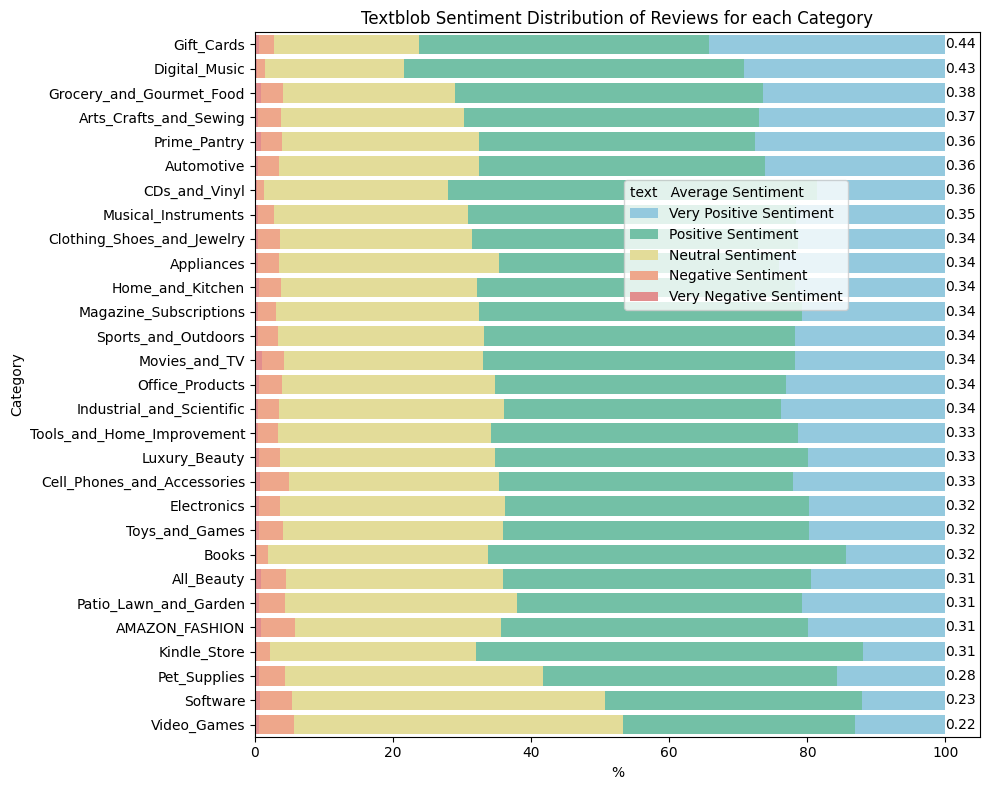

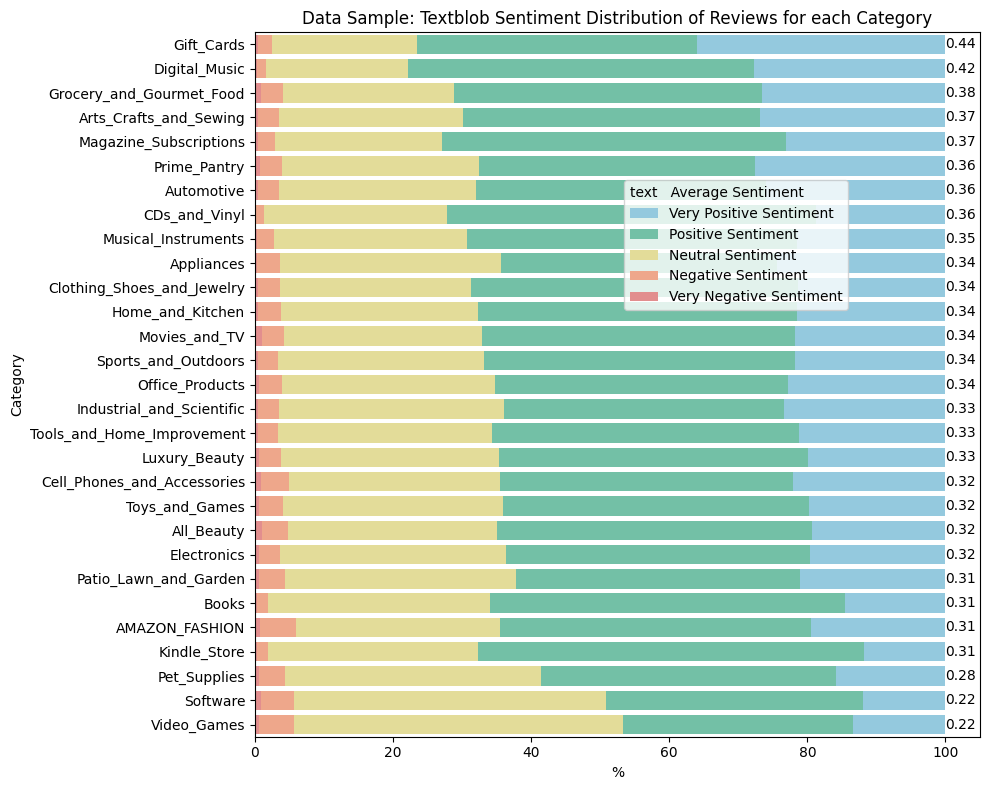

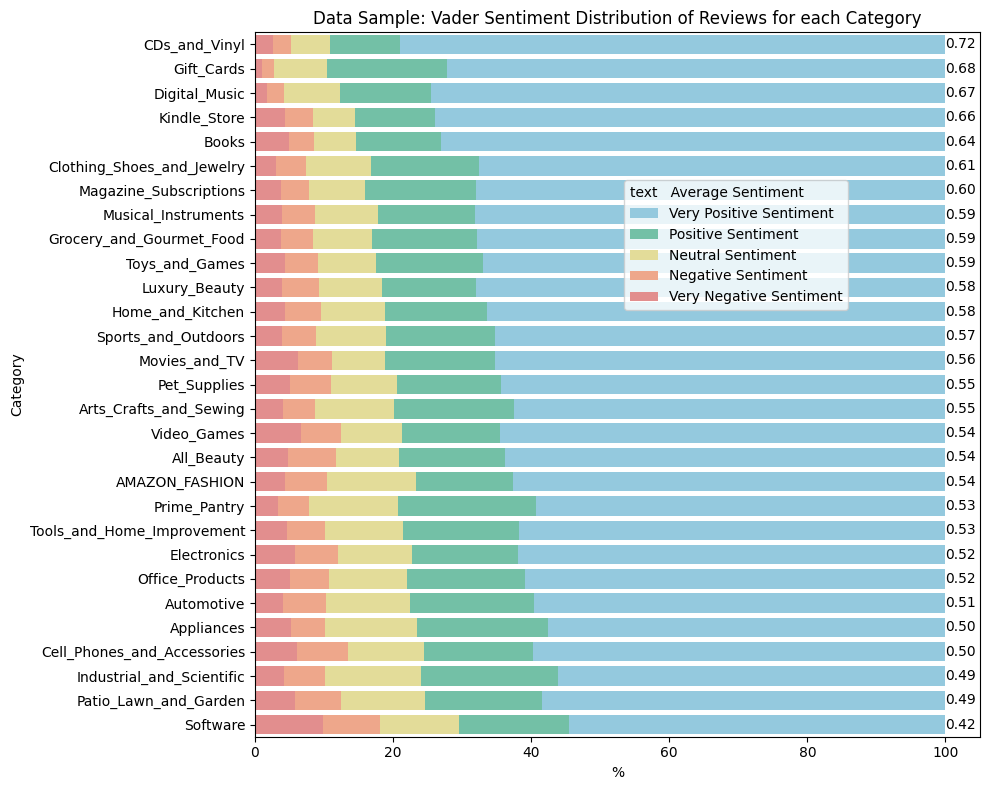

In [14]:
def plot_cat_sentiment(title, df_cat_sentiment):
    # Calculate comulative values
    com_df_cat_sentiment = df_cat_sentiment.copy()
    sentiments = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    for i in range(0, 4):
        com_df_cat_sentiment[sentiments[i+1]] += com_df_cat_sentiment[sentiments[i]]
    # Normalize and convert to Percent
    for i in range(0, 5):
        com_df_cat_sentiment[sentiments[i]] *= 100 / com_df_cat_sentiment[sentiments[4]]


    com_df_cat_sentiment = com_df_cat_sentiment.sort_values(by=['average_sentiment'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='very_positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[0], label='Very Positive Sentiment')
    sns.barplot(x='positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[1], label='Positive Sentiment')
    sns.barplot(x='neutral', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[2], label='Neutral Sentiment')
    sns.barplot(x='negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[3], label='Negative Sentiment')
    sns.barplot(x='very_negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[4], label='Very Negative Sentiment')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_sentiment.iterrows():
        ax1.text(row['very_positive'], i, f'{row["average_sentiment"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title(title)

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.5, 0.8), title='text   Average Sentiment', alignment='left')


    # Show the plot
    plt.show()

plot_cat_sentiment('Textblob Sentiment Distribution of Reviews for each Category', data_textblob_cat_sentiment)
plot_cat_sentiment('Data Sample: Textblob Sentiment Distribution of Reviews for each Category', data_sample_textblob_cat_sentiment)
plot_cat_sentiment('Data Sample: Vader Sentiment Distribution of Reviews for each Category', data_sample_vader_cat_sentiment)

In [24]:
outlier_detection('Textblob Average Sentiment Outliers', data_textblob_cat_sentiment, 'average_sentiment')
outlier_detection('Data Sample - TextBlob Average Sentiment Outliers', data_sample_textblob_cat_sentiment, 'average_sentiment')
outlier_detection('Data Sample - Vader Average Sentiment Outliers', data_sample_vader_cat_sentiment, 'average_sentiment')

Textblob Average Sentiment Outliers
         category  average_sentiment
9   Digital_Music           0.429375
11     Gift_Cards           0.435075
24       Software           0.226293
28    Video_Games           0.221828
Data Sample - TextBlob Average Sentiment Outliers
         category  average_sentiment
9   Digital_Music           0.422456
11     Gift_Cards           0.438908
24       Software           0.223885
28    Video_Games           0.221733
Data Sample - Vader Average Sentiment Outliers
        category  average_sentiment
6  CDs_and_Vinyl           0.719027


## Correlation between Star Rating and Sentiment
The following scatterplots suggest a correlation between sentiment and star rating values. Lower sentiment reviews tend to correspond to lower star ratings. Notably, the categories Giftcards, Digital Music and Software stand out as clear outliers in all three plots. Addressing a part of our question, as it is evident that there are notable differences between the categories concerning the average positivity of the reviews. 

NameError: name 'data_sample_cat_stars' is not defined

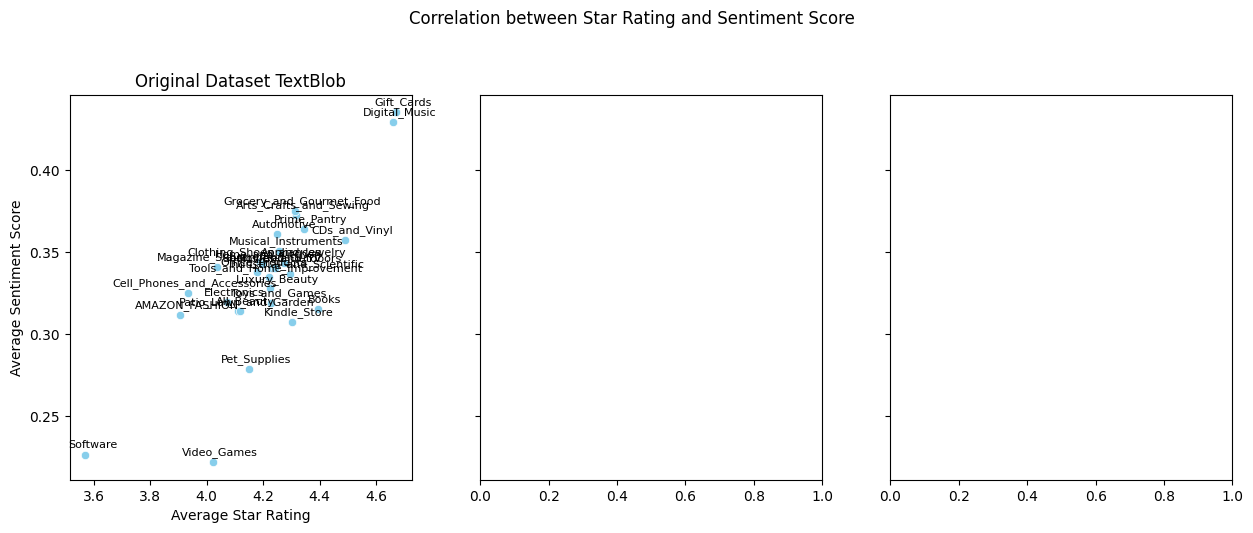

In [15]:
def plot_correlation_stars_sentiment(title, df_stars, df_sentiment, ax):
    df_merged = df_stars.merge(df_sentiment, on='category', how='left')[['category', 'average_rating', 'average_sentiment']]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    sns.scatterplot(x='average_rating', y='average_sentiment', data=df_merged, ax=ax, color="#87CEEB")

    # Annotate each point with the category name
    for i, row in df_merged.iterrows():
        ax.annotate(row['category'], (row['average_rating'], row['average_sentiment']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)


    # Customize plot labels and title
    ax.set_xlabel('Average Star Rating')
    ax.set_ylabel('Average Sentiment Score')
    ax.set_title(title)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig.suptitle('Correlation between Star Rating and Sentiment Score', y=1.05)
plot_correlation_stars_sentiment('Original Dataset TextBlob', data_cat_stars, data_textblob_cat_sentiment, axes[0])
plot_correlation_stars_sentiment('Sample Data TextBlob', data_sample_cat_stars, data_sample_textblob_cat_sentiment, axes[1])
plot_correlation_stars_sentiment('Sample Data Vader Sentiment', data_sample_cat_stars, data_sample_vader_cat_sentiment, axes[2])

# Tight layout and legend
plt.tight_layout()

# Show the plot
plt.show()


The plot illustrates the distribution of ratings within each sentiment classification, where the percentages are calculated within the respective sentiment class. This approach enables a more focused examination of differences within specific groups. It's worth noting that the distribution of the number of stars per rating is skewed. For instance, in the case of very negative sentiment, there are more 5-star reviews than 3-star reviews. Despite this skewness, a comparison of bars for each rating reveals clear patterns. The percentage of 5-star reviews is highest when associated with very positive sentiment, while the highest percentage of 1-star reviews is found in conjunction with very negative sentiment.

Similarly to the earlier observation regarding the alignment between Vader sentiment compound scores and star ratings, a similar pattern is evident in this analysis. Notably, each rating exhibits its largest bar within its corresponding sentiment subgraph.

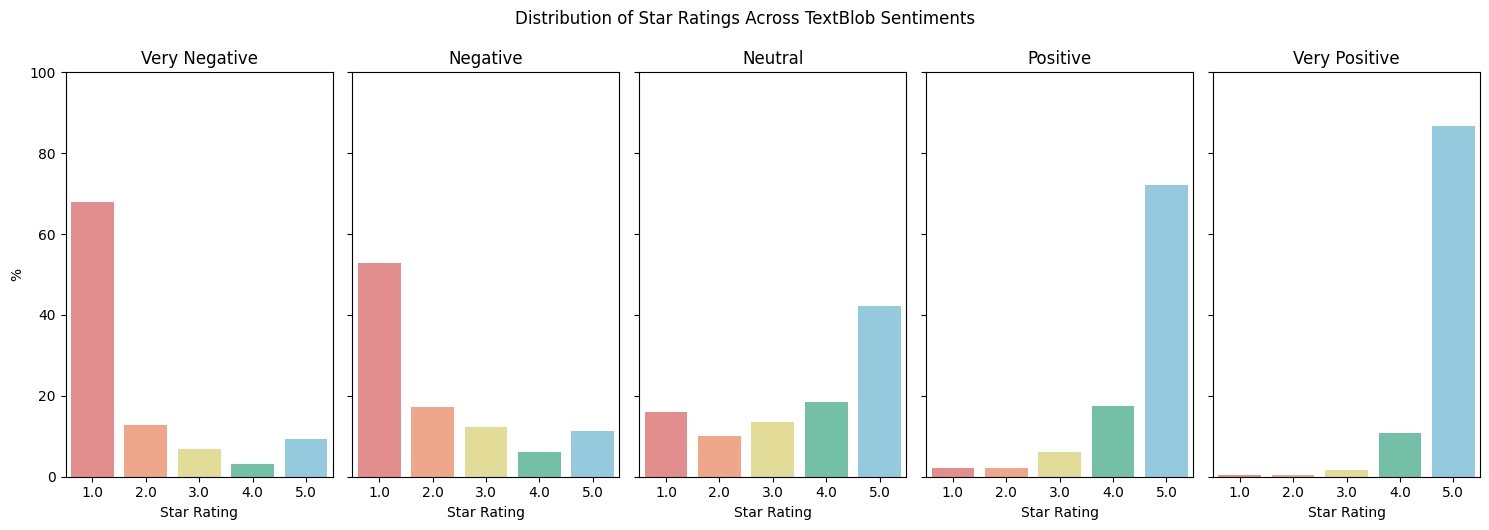

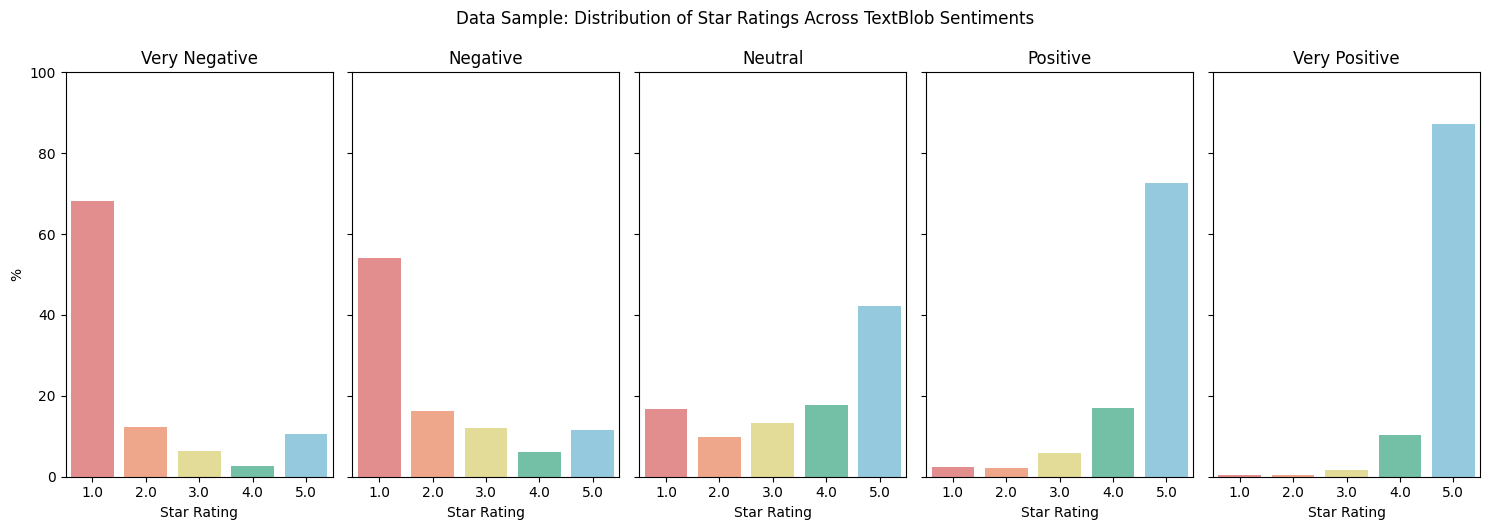

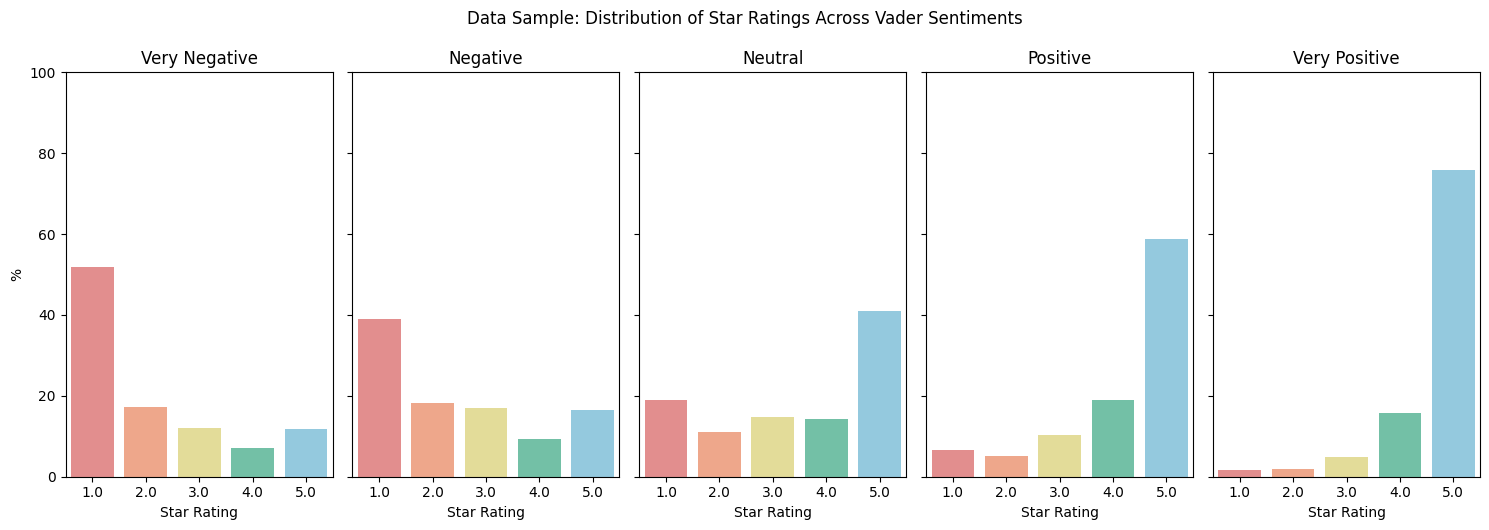

In [ ]:
def plot_hist_comparison(title, data_sentiment):
    long_df = data_sentiment.groupBy('overall', 'sentiment').count()
    df = long_df.groupBy('overall').pivot('sentiment').sum("count")
    df = df.orderBy('overall').toPandas()

    sentiments = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    # Normalize and convert to Percent
    for i in range(0, 5):
        df[sentiments[i]] *= 100 / df[sentiments[i]].sum()

    # Pastel-toned colors
    pastel_palette = ["#F08080", "#FFA07A", "#F0E68C", "#66CDAA", "#87CEEB"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5), sharey=True)
    for i, sentiment in enumerate(sentiments):
        sns.barplot(x='overall', y=sentiment, data=df, palette=pastel_palette, hue='overall', ax=axes[i], dodge=False)
        axes[i].set_title(sentiment.replace('_', ' ').title())
        axes[i].set_xlabel('Star Rating')
        axes[i].set_ylabel('%')
        axes[i].legend_.remove()
        axes[i].set_ylim(0, 100)

    # Tight layout and Title
    plt.tight_layout()
    # Set a single title for all plots
    fig.suptitle(title, y=1.05)

    # Show the plot
    plt.show()

plot_hist_comparison('Distribution of Star Ratings Across TextBlob Sentiments', data_textblob_sentiment)
plot_hist_comparison('Data Sample: Distribution of Star Ratings Across TextBlob Sentiments', data_sample_textblob_sentiment)
plot_hist_comparison('Data Sample: Distribution of Star Ratings Across Vader Sentiments', data_sample_vader_sentiment)